# Split-apply-combine

When investigating properties within our datasets, it is often the case that we will want to categorise or downsample that data. This could include looking at averages (or other bulk properties) within different classes, averages across different time periods or selecting only the first of repeated entries.

We could approach this by looping and filtering our data set, applying an operation to each sub set in a manual way. However, pandas offers us a more efficient and flexible strategy called **split-apply-combine**, where we can achieve the same output by splitting the data into groups, applying an operation on each group and combining the data back together, sometimes in a few lines of code.

## Groupby

The main example of this is strategy is when using the `groupby()` function.

In [11]:
import pandas as pd
import numpy as np

degree_units = pd.DataFrame({"unit":["Life Processes", "Microbiology", "Statistics", "Ancient Saxons", "Analysis"],
                             "degree":["Biology", "Biology", "Mathematics", "Archaeology", "Mathematics"],
                             "students_enrolled": [100, 150, np.nan, 50, 300]})
degree_units

,unit,degree,students_enrolled
0,Life Processes,Biology,100.0
1,Microbiology,Biology,150.0
2,Statistics,Mathematics,NaN
3,Ancient Saxons,Archaeology,50.0
4,Analysis,Mathematics,300.0


In [12]:
degree_units.groupby("degree").mean(numeric_only=True)

,students_enrolled
degree,
Archaeology,50.0
Biology,125.0
Mathematics,300.0


For this DataFrame, this has been grouped by degree title and the mean calculated for each of those groups. This was done by first calling the [`.groupby()` method](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) followed by the [`.mean()` method](https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.GroupBy.mean.html). One thing to notice here is that the column we grouped on is now being used as the index in our new DataFrame.

***Be aware**: in this case, the output DataFrame doesn't have the "unit" column that was in the input DataFrame. This is because the `mean()` function cannot be used on this column because it contained strings and so it has been silently dropped. This may or not be desired behaviour, but is worth being aware of when applying these sorts of operations.*

If we look at these two steps, we can start to break down what is happening here:

In [10]:
degree_grouped = degree_units.groupby("degree")
print(degree_grouped)

This is a [GroupBy object](https://pandas.pydata.org/docs/reference/groupby.html). It is a bit opaque and doesn't give you much information if you just print it out. However, if you loop over this it will give you both the name of each category and the details of the group:

In [13]:
for name, group in degree_grouped:
    print(f"Name: {name}")
    print(group)
    print("\n") # Print a new line (blank line)

Name: Archaeology
             unit       degree  students_enrolled
3  Ancient Saxons  Archaeology               50.0


Name: Biology
             unit   degree  students_enrolled
0  Life Processes  Biology              100.0
1    Microbiology  Biology              150.0


Name: Mathematics
         unit       degree  students_enrolled
2  Statistics  Mathematics                NaN
4    Analysis  Mathematics              300.0




So when you use `.mean()` here you are using a function (method) on this GroupBy object. It applies this function to each of these groups seperately and then combines these details back together to give you a new DataFrame:

In [15]:
degree_grouped.mean(numeric_only=True)

,students_enrolled
degree,
Archaeology,50.0
Biology,125.0
Mathematics,300.0


Using the [`.mean()` method](https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.GroupBy.mean.html) is an example of an *aggregation* function i.e. one that reduces each group to a single row. Pandas provides a set of these aggregation functions you can use. See here for some more examples and a table of the aggregation functions available: https://pandas.pydata.org/docs/user_guide/groupby.html#aggregation.

There are also other operations which you can use rather than aggregation (including [transforming](https://pandas.pydata.org/docs/user_guide/groupby.html#transformation) and [filtering](https://pandas.pydata.org/docs/user_guide/groupby.html#filtration)) but we will leave that up to you to explore if you're interested.

And it is also possible to apply any function which produces a suitable output using the [`.apply()` equivalent method](https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.GroupBy.apply.html) ([examples](https://pandas.pydata.org/docs/user_guide/groupby.html#flexible-apply)) available.

---

### Aside: file systems

Accessing external files, such as data files, on different operating systems (Linux, MacOS, Windows) can sometimes be tricky. There are a few libraries available in Python which can help with this.

The [`os` module](https://docs.python.org/3/library/os.html) (operating system interfaces module) provides some useful functions when running Python on your own device. For example the `getcwd()` command tells you where this current file is (get current working directory).

In [16]:
import os

current_directory = os.getcwd()
print(current_directory)

C:\Users\petes\Workshops\Workshop03


On my University Windows laptop this is a string which looks like:

```
C:\Users\rt17603\OneDrive - University of Bristol\Documents\Teaching\Materials\Intermediate Scientific Computing\intermediate-scientific-computing\Workshop03
```

*Note: this output will look different depending on where this notebook is being run (e.g. Noteable versus your own device versus my device etc.).*

When accessing files, we often need to indicate where that file is stored. Another useful module is the [`pathlib` module](https://docs.python.org/3/library/pathlib.html). This allows you to create a `Path` object which can be used to handle paths for files for all different operating systems and can sensibly interpret these.

In [17]:
from pathlib import Path
current_path = Path(current_directory)
current_path

WindowsPath('C:/Users/petes/Workshops/Workshop03')

On my University Windows laptop this looks like:

```
WindowsPath('C:/Users/rt17603/OneDrive - University of Bristol/Documents/Teaching/Materials/Intermediate Scientific Computing/intermediate-scientific-computing/Workshop03')
```

You can see this has correctly interpreted this as a Windows Path. You can update this path to incldue sub-folders and filenames using the `/` syntax to combine with strings (or other Path objects):

In [18]:
filename_with_path = current_path / "data" / "untitled.txt"
filename_with_path

WindowsPath('C:/Users/petes/Workshops/Workshop03/data/untitled.txt')

On my University Windows laptop this looks like:

```
WindowsPath('C:/Users/rt17603/OneDrive - University of Bristol/Documents/Teaching/Materials/Intermediate Scientific Computing/intermediate-scientific-computing/Workshop03/data/untitled.txt')
```

You can also create *relative paths* (paths which are relative to your location) for sub-directories (we have been doing this so far on this unit when we write "data/data_file.csv") or using "../" for each directory level you wish to go up.

For example, if your "Workshop03" folder is in the same location as your "Workshop02" folder and you wanted to access the database from the previous workshop you could write

In [19]:
filename = Path("../Workshop02/data/ukpvgeo.db")
print(filename)

..\Workshop02\data\ukpvgeo.db


**Question:** Could you write a full path to the "ukpvgeo.db" database using tools from `os` and/or the `pathlib` library?

---

### Exercise A

When we looked at our UKPVGeo dataset last week, a groupby was used to look at the mean properties within each county. 

To access this database again, the simplest way would be to copy the database from Workshop02/data/ukpvgeo.db to the same location at this notebook. 

*Optionally, using the tools described above you could try to write a full or relative path to access the original database from Workshop 2. This will be dependent on your file system and how you have stored the files.*

Using the rules for accessing SQL data from ["Workshop02/Workshop2_01_Databases.ipynb"](../Workshop02/Workshop2_01_Databases.ipynb) (also see ["Workshop02/Workshop2_02_Operations.ipynb"](../Workshop02/Workshop2_02_Operations.ipynb#Solar-panel-database)), answer the questions below.

1) Access the UKPVGeo SQLite database and group on the status column

 - When accessing this database, write a query to extract the "repd_status" and the "area_sqm" columns.

 - Write a groupby to group on this status column and calculate the mean.

 - What is the mean area for the solar panels / farms listed as operational?

In [28]:
database = Path("../Workshop 2/data/ukpvgeo.db")
database_service = "sqlite"
connectable = f"{database_service}:///{database}"
query = "SELECT repd_status, area_sqm FROM pv"
ukpvgeo = pd.read_sql(query, connectable)
ukpvgeo_groupby = ukpvgeo.groupby("repd_status")
mean = ukpvgeo_groupby.mean(numeric_only=True)
mean

,area_sqm
repd_status,
Application Submitted,31802.664706
Awaiting Construction,62234.170312
Operational,26492.179936
Under Construction,56155.061538


2) For the same DataFrame, group on the status column but this time find a way to *count the number* of solar cells listed as operational.

*You may want to look through the different [methods available](https://pandas.pydata.org/docs/user_guide/groupby.html#aggregation)*

In [32]:
ukpvgeo_groupby.count()

,area_sqm
repd_status,
Application Submitted,17
Awaiting Construction,64
Operational,8458
Under Construction,13


---

## Resample

When we consider resampling, this ties closely to the idea of measuring a timeseries of data. It is often the case that we have data on a certain frequency but wish to average over longer time periods, perhaps to look for longer term trends or to group together noisy data.

Here we have generated  sample data to simulate measuring the concentration of two samples over time:

In [33]:
## Generating sample data
import numpy.random as random

# Using the pandas date_range function with 30s frequency to create timeseries
times = pd.date_range("2020-03-08T13:39:30", "2020-03-08T14:31:00", freq="30s")
num_data_points = len(times)

rng = random.default_rng(seed=109)
conc_1 = np.linspace(0, 10, num_data_points) + rng.random(num_data_points)
conc_2 = np.linspace(4, 0, num_data_points) + rng.random(num_data_points)

experiment = pd.DataFrame({"concentration_x":conc_1, "concentration_y":conc_2}, index=times)

Matplotlib is building the font cache; this may take a moment.


<Axes: >

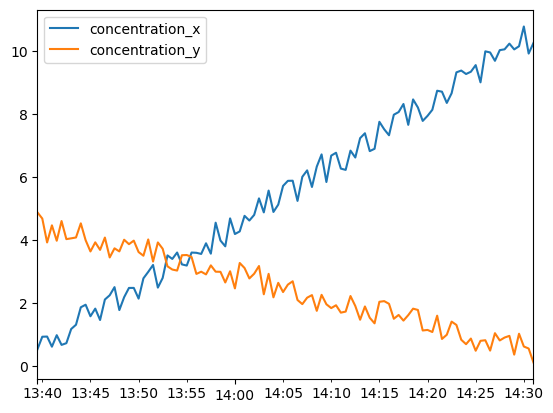

In [34]:
experiment.plot()

This sample data is currently at a frequency of 30 seconds. We can see an overall trend but the data itself is noisy.

We can resample this to a lower frequency, for instance 5 minutes and take the mean within each sample in the following way:

<Axes: >

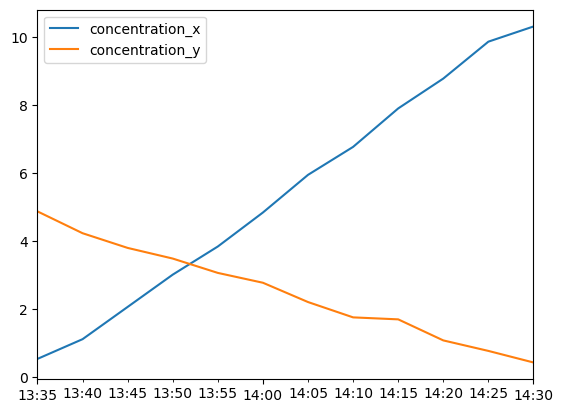

In [35]:
experiment_downsample = experiment.resample("5min").mean()
experiment_downsample.plot()

This is very similiar to the `groupby` syntax, but this time we first call the [`resample()` method]() and then the `.mean()` method. 

When we call the `resample()` method, this is where we can specify a new frequency, as a string containing a number and a unit. For example this could be:
- "5min" (5 minutes)
- "1H" (1 hour)
- "3MS" (3 months, from month start)
- "1.234Y" (1.234 years, from year end)

See here for all of the [options available for pandas time units](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases)

Similiarly, to `groupby` there are also [lots of methods](https://pandas.pydata.org/pandas-docs/stable/reference/resampling.html#computations-descriptive-stats) available  which can be called as well as `mean()`.

It is worth considering what is happening when we call the resample method. As with `groupby()`, we can split this process up into multiple steps and look at the object created when we call `resample()`:

In [36]:
experiment_resample = experiment.resample("5min")
print(experiment_resample)

DatetimeIndexResampler [freq=<5 * Minutes>, axis=0, closed=left, label=left, convention=start, origin=start_day]


This is a [Resampler object](https://pandas.pydata.org/docs/reference/resampling.html) (very similiar to a GroupBy object) and we can loop over this to see how this data has been split:

In [37]:
for bin_start, group in experiment_resample:
    print(f"Bin start: {bin_start}")
    print(group)
    print("\n")

Bin start: 2020-03-08 13:35:00
                     concentration_x  concentration_y
2020-03-08 13:39:30         0.543742         4.882993


Bin start: 2020-03-08 13:40:00
                     concentration_x  concentration_y
2020-03-08 13:40:00         0.938496         4.688915
2020-03-08 13:40:30         0.944251         3.930420
2020-03-08 13:41:00         0.622898         4.473455
2020-03-08 13:41:30         0.987603         3.985018
2020-03-08 13:42:00         0.679938         4.609630
2020-03-08 13:42:30         0.733967         4.035999
2020-03-08 13:43:00         1.183498         4.060859
2020-03-08 13:43:30         1.319334         4.088603
2020-03-08 13:44:00         1.873196         4.536534
2020-03-08 13:44:30         1.954733         4.001805


Bin start: 2020-03-08 13:45:00
                     concentration_x  concentration_y
2020-03-08 13:45:00         1.588349         3.645174
2020-03-08 13:45:30         1.830758         3.933834
2020-03-08 13:46:00         1.469568   

So, the resample method has split our data up into 5 minute bins. The first bin starts at "2020-03-08 13:35:00", the second at "2020-03-08 13:40:00" and so forth. 

**Question**: For our data, why does the first bin only contain one data point?

Aside: As well as `groupby()` and `resample()`, other methods you may come across that use similiar principles are the [`rolling()` method](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html) and the [`expanding()` method](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.expanding.html) (known as window operations).

---

### Exercise B

1) For the `experiment` data defined above, can you resample this to find the average over hourly increments. How many rows did this produce?

In [38]:
experiment_resample = experiment.resample("1H")
for bin_start, group in experiment_resample:
    print(f"Bin start: {bin_start}")
    print(group)
    print("\n")


Bin start: 2020-03-08 13:00:00
                     concentration_x  concentration_y
2020-03-08 13:39:30         0.543742         4.882993
2020-03-08 13:40:00         0.938496         4.688915
2020-03-08 13:40:30         0.944251         3.930420
2020-03-08 13:41:00         0.622898         4.473455
2020-03-08 13:41:30         0.987603         3.985018
2020-03-08 13:42:00         0.679938         4.609630
2020-03-08 13:42:30         0.733967         4.035999
2020-03-08 13:43:00         1.183498         4.060859
2020-03-08 13:43:30         1.319334         4.088603
2020-03-08 13:44:00         1.873196         4.536534
2020-03-08 13:44:30         1.954733         4.001805
2020-03-08 13:45:00         1.588349         3.645174
2020-03-08 13:45:30         1.830758         3.933834
2020-03-08 13:46:00         1.469568         3.695162
2020-03-08 13:46:30         2.119467         4.085823
2020-03-08 13:47:00         2.254558         3.454943
2020-03-08 13:47:30         2.512743         3.7439

2) How would you find the minimum value for every 10 minutes in the `experiment` data?

In [39]:
experiment_resample = experiment.resample("10min")
experiment_resample.min()

,concentration_x,concentration_y
2020-03-08 13:30:00,0.543742,4.882993
2020-03-08 13:40:00,0.622898,3.454943
2020-03-08 13:50:00,2.148157,2.660763
2020-03-08 14:00:00,4.197829,1.760587
2020-03-08 14:10:00,6.233531,1.136930
2020-03-08 14:20:00,7.947414,0.370911
2020-03-08 14:30:00,9.924823,0.121689


---